In [2]:
import torch
import numpy as np
import math
from d2l import torch as d2l
from torch import nn

$$
y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, 0.1^2)
$$

In [3]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[2.3543],
         [0.4799]]),
 tensor([[1.0000e+00, 2.3543e+00, 2.7713e+00, 2.1748e+00, 1.2800e+00, 6.0269e-01,
          2.3648e-01, 7.9535e-02, 2.3406e-02, 6.1226e-03, 1.4414e-03, 3.0850e-04,
          6.0524e-05, 1.0961e-05, 1.8432e-06, 2.8929e-07, 4.2567e-08, 5.8949e-09,
          7.7101e-10, 9.5535e-11],
         [1.0000e+00, 4.7991e-01, 1.1515e-01, 1.8421e-02, 2.2101e-03, 2.1213e-04,
          1.6967e-05, 1.1632e-06, 6.9779e-08, 3.7208e-09, 1.7856e-10, 7.7904e-12,
          3.1155e-13, 1.1501e-14, 3.9425e-16, 1.2614e-17, 3.7833e-19, 1.0680e-20,
          2.8475e-22, 7.1922e-24]]),
 tensor([10.5777,  5.3887]))

In [5]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(
        train_features, test_features, 
        train_labels, test_labels, num_epochs=400):
    
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)), batch_size
    )
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1, 1)), batch_size
    )
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss', yscale='log',
        xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test']
    )
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1, 
                (evaluate_loss(net, train_iter, loss), 
                 evaluate_loss(net, test_iter, loss)))
    print('wight:', net[0].weight.data.numpy())

wight: [[ 4.9949627  1.2595762 -3.3752062  5.4376407]]


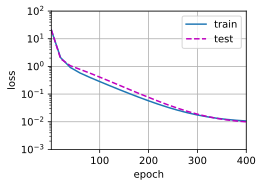

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

wight: [[3.488746  3.1574037]]


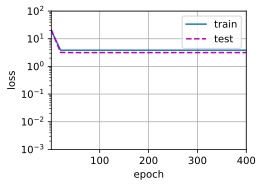

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

wight: [[ 4.98364     1.2339468  -3.283254    5.2939315  -0.4143023   1.38185
  -0.13834265  0.35166273 -0.09468223  0.05520042  0.21933083  0.05402826
   0.1261692  -0.01378878  0.20395993  0.19970316  0.13500316 -0.12651892
   0.0407187   0.20184202]]


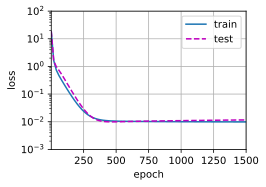

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)